Generative Adversarial Network

Reference:
<https://github.com/lyeoni/pytorch-mnist-GAN>

In [14]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [16]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [17]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim=z_dim, g_output_dim=mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

def train(epochs=20):
    # loss
    criterion = nn.BCELoss() 

    # optimizer
    lr = 0.0002 
    G_optimizer = optim.Adam(G.parameters(), lr = lr)
    D_optimizer = optim.Adam(D.parameters(), lr = lr)
    
    def D_train(x):
        #=======================Train the discriminator=======================#
        D.zero_grad()

        # train discriminator on real
        x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
        x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

        D_output = D(x_real)
        D_real_loss = criterion(D_output, y_real)
        D_real_score = D_output

        # train discriminator on facke
        z = Variable(torch.randn(bs, z_dim).to(device))
        x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

        D_output = D(x_fake)
        D_fake_loss = criterion(D_output, y_fake)
        D_fake_score = D_output

        # gradient backprop & optimize ONLY D's parameters
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        return  D_loss.data.item()

    def G_train(x):
        #=======================Train the generator=======================#
        G.zero_grad()

        z = Variable(torch.randn(bs, z_dim).to(device))
        y = Variable(torch.ones(bs, 1).to(device))

        G_output = G(z)
        D_output = D(G_output)
        G_loss = criterion(D_output, y)

        # gradient backprop & optimize ONLY G's parameters
        G_loss.backward()
        G_optimizer.step()

        return G_loss.data.item()
    
    for epoch in range(1, epochs+1):           
        D_losses, G_losses = [], []
        prefix = f"Training Epoch {epoch}/{epochs}: "
        pbar = tqdm(train_loader, desc=prefix,
                dynamic_ncols=True, leave=True,
                position=0, file=sys.stdout)
        for batch_idx, (x, _) in enumerate(pbar):
            D_losses.append(D_train(x))
            G_losses.append(G_train(x))
        pbar.write("Training Epoch {}/{}: D loss: {:.3f}, G loss: {:.3f}".format(
                epoch, epochs, torch.mean(torch.FloatTensor(D_losses)),
                torch.mean(torch.FloatTensor(G_losses))))

should_create_new_instance = True
if should_create_new_instance:
    train()
    torch.save(G.state_dict(), './models/gan-G.pth')
    torch.save(D.state_dict(), './models/gan-D.pth')
else:
    G.load_state_dict(torch.load('./models/gan-G.pth'))
    D.load_state_dict(torch.load('./models/gan-D.pth'))

Training Epoch 1/20: 100%|██████████| 600/600 [00:09<00:00, 61.93it/s]
Training Epoch 1/20: D loss: 0.990, G loss: 3.033
Training Epoch 2/20: 100%|██████████| 600/600 [00:09<00:00, 62.14it/s]
Training Epoch 2/20: D loss: 1.034, G loss: 1.444
Training Epoch 3/20: 100%|██████████| 600/600 [00:09<00:00, 61.98it/s]
Training Epoch 3/20: D loss: 0.857, G loss: 2.483
Training Epoch 4/20: 100%|██████████| 600/600 [00:09<00:00, 61.79it/s]
Training Epoch 4/20: D loss: 0.652, G loss: 2.462
Training Epoch 5/20: 100%|██████████| 600/600 [00:09<00:00, 61.43it/s]
Training Epoch 5/20: D loss: 0.480, G loss: 2.556
Training Epoch 6/20: 100%|██████████| 600/600 [00:09<00:00, 61.12it/s]
Training Epoch 6/20: D loss: 0.522, G loss: 2.681
Training Epoch 7/20: 100%|██████████| 600/600 [00:09<00:00, 61.25it/s]
Training Epoch 7/20: D loss: 0.588, G loss: 2.412
Training Epoch 8/20: 100%|██████████| 600/600 [00:09<00:00, 61.07it/s]
Training Epoch 8/20: D loss: 0.625, G loss: 2.410
Training Epoch 9/20: 100%|██████

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


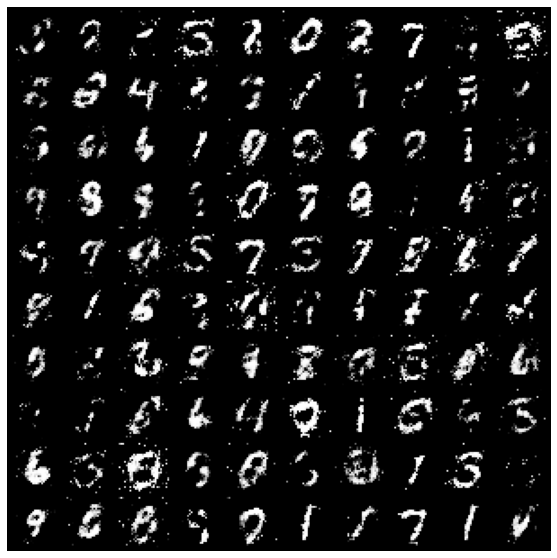

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)
    # grid_img has shape (100, 1, 28, 28)
    batch_tensor = generated.view(generated.size(0), 1, 28, 28)
    grid_img = torchvision.utils.make_grid(batch_tensor, nrow=10)
    grid_img = grid_img.permute(1, 2, 0).cpu().detach().numpy()
    ax.imshow(grid_img)
    ax.axis('off')